# Functional API
- Sequential 모델은 각 Layer들의 입력과 출력이 하나라고 가정. 그리고 각각의 Layer(입력층, 은닉층, 출력층)들을 차례대로 쌓아 구성
- 함수형 API를 사용하면 **다중입력, 다중출력, 그래프 형태**의 다양한 형태의 모델을 유연하게 구성 가능

- Functional API는 직접 텐서들의 입출력을 다룸
- 함수호출처럼 Layer를 이용하여 텐서를 입력 받고 출력하는 형식으로 모델을 구현
    - 코드상에서는 Layer를 입력받는 형식으로 작성


```
input_tensor = Input(shape=(16,))
dense = layers.Dense(32, activation='relu')(input_tensor)
output_tensor = layers.Dense(32, activation='sigmoid')(dense)

model = models.Model(input_tensor, output_tensor)
```

In [12]:
# Python의 magic method
# 객체를 함수처럼 불러서 쓸 수 있게 됨
class Test:
    def __init__(self, name):
        self.name = name
   # 객체를 함수처럼 호출할 수 있게 해주는 특수 메소드 - special method, 던더메서드
    def __call__(self):
        print("__call__", self.name)
    def __str__(self):
        return "문자열"
    def m(self):
        print('M')

In [13]:
t = Test('홍길동')

In [14]:
# t.m(), t.name

In [11]:
t()

__call__ 홍길동


In [15]:
str(t)

'문자열'

In [16]:
Test('홍길동')()

__call__ 홍길동


## Sequential, Functional API 

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models

### Sequential

In [19]:
seq_model = keras.Sequential()
seq_model.add(layers.Input(shape = (32, 32, 3)))
seq_model.add(layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
seq_model.add(layers.Flatten())
seq_model.add(layers.Dense(units = 256, activation = 'relu'))
# layer에 이름 지정
seq_model.add(layers.Dense(units = 10, activation = 'softmax', name = 'output_layer'))
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16777472  
_________________________________________________________________
output_layer (Dense)         (None, 10)                2570      
Total params: 16,781,834
Trainable params: 16,781,834
Non-trainable params: 0
_________________________________________________________________


### Functional

In [12]:
input_tensor = layers.Input(shape = (32, 32, 3))
conv_tensor = layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(input_tensor)
pool_tensor = layers.MaxPool2D(padding = 'same')(conv_tensor)

flatten_tensor = layers.Flatten()(pool_tensor)

dense_tensor = layers.Dense(units = 256, activation = 'relu')(flatten_tensor)
dense_tensor2 = layers.Dense(units = 128)(dense_tensor)

bn_tensor = layers.BatchNormalization()(dense_tensor2)
relu_tensor = layers.ReLU()(bn_tensor)

output_tensor = layers.Dense(units = 10, activation = 'softmax')(relu_tensor)

# (입력텐서, 출력텐서)
fn_model = models.Model(input_tensor, output_tensor)

fn_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               4194560   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512 

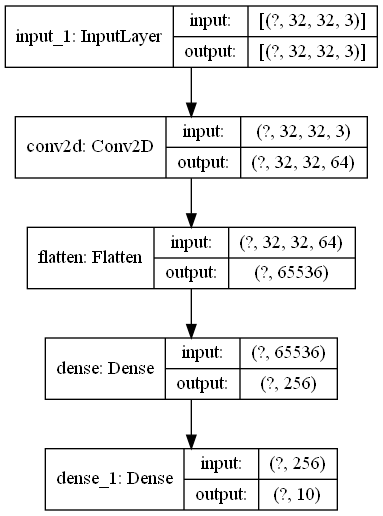

In [5]:
keras.utils.plot_model(fn_model, show_shapes = True)

In [15]:
# 재사용할 필요 없다면, 변수 통일(input_tensor, output_tensor 제외)
input_tensor = layers.Input(shape = (32, 32, 3))
x = layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(input_tensor)
x = layers.MaxPool2D(padding = 'same')(x)

x = layers.Flatten()(x)

x = layers.Dense(units = 256, activation = 'relu')(x)
x = layers.Dense(units = 128)(x)

x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

output_tensor = layers.Dense(units = 10, activation = 'softmax')(x)

# (입력텐서, 출력텐서)
fn_model = models.Model(input_tensor, output_tensor)

fn_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               4194560   
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512 

## 레이어를 합치는 함수
- concatenate(list, axis=-1)
    - 레이어들을 합침
    - list: 합칠 레이어들을 리스트에 묶어 전달
    - axis: 합칠 기준축(기본값: -1 : 마지막 축 기준)
- add(list), substract(list), multiply(list)
    - 같은 index의 값들을 계산해서(더하기, 빼기, 곱하기) 하나의 레이어로 만듬
    - list: 합칠 레이어들을 리스트에 묶어 전달

In [16]:
# Residual block
input_tensor = layers.Input((32, 32, 3))
x = layers.Conv2D(64,kernel_size = 3, padding = 'same', activation = 'relu')(input_tensor)
x1 = layers.Conv2D(64, kernel_size = 3, padding = 'same')(x)
b1 = layers.BatchNormalization()(x1)
add1 = layers.add([x, b1])
r = layers.ReLU()(add1)

r_block_model = models.Model(input_tensor, r)

In [17]:
r_block_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 64)   1792        input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 64)   36928       conv2d_11[0][0]                  
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 32, 32, 64)   256         conv2d_12[0][0]                  
____________________________________________________________________________________________

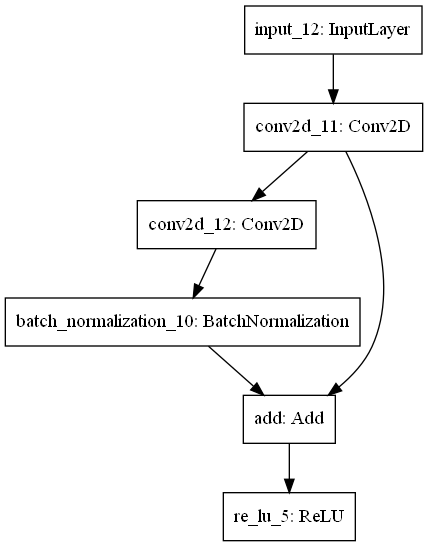

In [18]:
keras.utils.plot_model(r_block_model)

### 다중 출력 모델
- 가정
    - iris 데이터셋에서 꽃받침의 너비와 높이로 꽃잎의 너비, 높이, 꽃 종류를 예측하는 모델
    - 출력결과가 3개가 나와야 함
- X: 꽃받침 너비, 높이
- y: 꽃잎 너비, 높이, 꽃 종류

In [19]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.23.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: c:\users\jiyoon\anaconda3\envs\tf2\lib\site-packages
Requires: scipy, threadpoolctl, joblib, numpy
Required-by: 


In [20]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris['data'], iris['target']
X.shape, y.shape

((150, 4), (150,))

In [21]:
y1 = X[:, 2]  # 꽃잎 너비
y2 = X[:, 3]  # 꽃잎 높이
y3 = y  # 품종

X = X[:, [0, 1]]

In [22]:
X.shape, y1.shape, y2.shape, y3.shape

((150, 2), (150,), (150,), (150,))

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [25]:
input_tensor = layers.Input((2, ))
x = layers.Dense(units = 16, activation = 'relu')(input_tensor)
x = layers.Dense(units = 8, activation = 'relu')(x)
output1 = layers.Dense(1, name = 'petal_width_output')(x)  # 꽃잎 너비 예측(Regression: units = 1, activation = x)
output2 = layers.Dense(1, name = 'petal_length_output')(x)  # 꽃잎 높이 예측(Regression: units = 1, activation = x)
output3 = layers.Dense(3, activation = 'softmax', name = 'species_output')(x)  # 품종 예측(다중분류: units - class 개수(3), activation = 'softmax')

# Model(input, output)
# input, output이 여러 개인 경우 리스트로 묶음
model = models.Model(input_tensor, [output1, output2, output3])

In [26]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 16)           48          input_13[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 8)            136         dense_27[0][0]                   
__________________________________________________________________________________________________
petal_width_output (Dense)      (None, 1)            9           dense_28[0][0]                   
____________________________________________________________________________________________

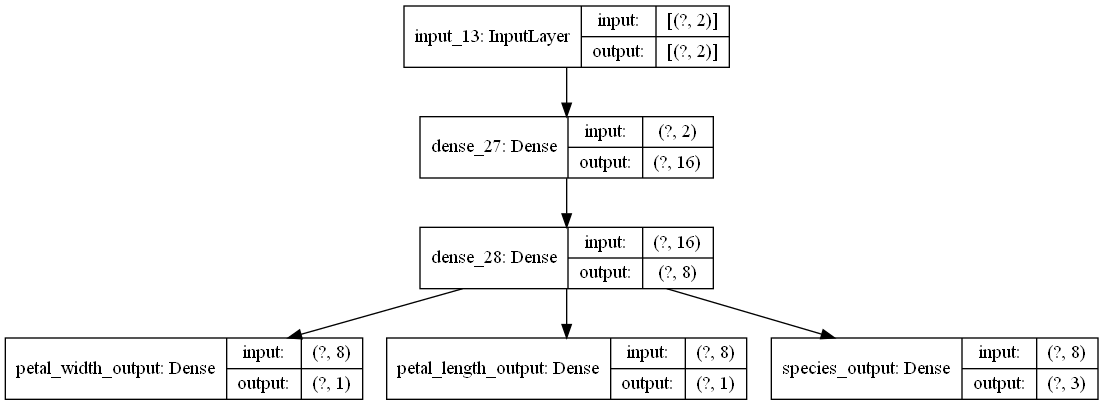

In [27]:
keras.utils.plot_model(model,show_shapes = True)

In [28]:
# compile
model.compile(optimizer = 'adam',
              # 출력이 3개 - 각각의 순서대로 Loss를 리스트로 묶어서 제공
              loss = ['mse', 'mse', 'sparse_categorical_crossentropy']) 
# 역전파를 통해 weight를 업데이트 할때는 위 3개의 Loss를 더한 총 Loss로 역전파 진행

In [30]:
history = model.fit(X, 
                    [y1, y2, y3],
                    epochs = 100,
                    validation_split = 0.1)

Train on 135 samples, validate on 15 samples
Epoch 1/100
135/135 [==============================] - 3s 24ms/sample - loss: 32.9376 - petal_width_output_loss: 23.1059 - petal_length_output_loss: 7.2971 - species_output_loss: 1.8652 - val_loss: 54.5606 - val_petal_width_output_loss: 39.3503 - val_petal_length_output_loss: 13.1686 - val_species_output_loss: 2.0417
Epoch 2/100
135/135 [==============================] - 0s 251us/sample - loss: 29.8088 - petal_width_output_loss: 21.1737 - petal_length_output_loss: 6.2525 - species_output_loss: 1.8208 - val_loss: 50.0462 - val_petal_width_output_loss: 36.6147 - val_petal_length_output_loss: 11.6848 - val_species_output_loss: 1.7467
Epoch 3/100
135/135 [==============================] - 0s 347us/sample - loss: 27.6674 - petal_width_output_loss: 19.8223 - petal_length_output_loss: 5.4951 - species_output_loss: 1.8039 - val_loss: 47.8999 - val_petal_width_output_loss: 35.6074 - val_petal_length_output_loss: 10.7125 - val_species_output_loss: 1.5

135/135 [==============================] - 0s 322us/sample - loss: 16.1207 - petal_width_output_loss: 11.8060 - petal_length_output_loss: 2.9094 - species_output_loss: 1.1992 - val_loss: 31.3277 - val_petal_width_output_loss: 22.4689 - val_petal_length_output_loss: 6.9626 - val_species_output_loss: 1.8962
Epoch 27/100
135/135 [==============================] - 0s 355us/sample - loss: 15.8846 - petal_width_output_loss: 11.8209 - petal_length_output_loss: 2.8794 - species_output_loss: 1.2546 - val_loss: 30.9539 - val_petal_width_output_loss: 21.9397 - val_petal_length_output_loss: 7.0739 - val_species_output_loss: 1.9403
Epoch 28/100
135/135 [==============================] - 0s 355us/sample - loss: 15.6328 - petal_width_output_loss: 11.8942 - petal_length_output_loss: 3.1052 - species_output_loss: 1.2733 - val_loss: 30.5423 - val_petal_width_output_loss: 21.3796 - val_petal_length_output_loss: 7.1785 - val_species_output_loss: 1.9843
Epoch 29/100
135/135 [==============================]

Epoch 52/100
135/135 [==============================] - 0s 364us/sample - loss: 6.1433 - petal_width_output_loss: 2.8965 - petal_length_output_loss: 2.2279 - species_output_loss: 1.2635 - val_loss: 11.8796 - val_petal_width_output_loss: 4.5027 - val_petal_length_output_loss: 5.3112 - val_species_output_loss: 2.0657
Epoch 53/100
135/135 [==============================] - 0s 384us/sample - loss: 5.8825 - petal_width_output_loss: 2.5269 - petal_length_output_loss: 1.9476 - species_output_loss: 1.1605 - val_loss: 11.1817 - val_petal_width_output_loss: 4.0989 - val_petal_length_output_loss: 5.0617 - val_species_output_loss: 2.0211
Epoch 54/100
135/135 [==============================] - 0s 412us/sample - loss: 5.6339 - petal_width_output_loss: 2.5556 - petal_length_output_loss: 1.8260 - species_output_loss: 1.1715 - val_loss: 10.5453 - val_petal_width_output_loss: 3.7461 - val_petal_length_output_loss: 4.8135 - val_species_output_loss: 1.9857
Epoch 55/100
135/135 [===========================

Epoch 78/100
135/135 [==============================] - 0s 318us/sample - loss: 3.7747 - petal_width_output_loss: 1.9635 - petal_length_output_loss: 0.4625 - species_output_loss: 1.0882 - val_loss: 4.5277 - val_petal_width_output_loss: 1.7383 - val_petal_length_output_loss: 1.4758 - val_species_output_loss: 1.3136
Epoch 79/100
135/135 [==============================] - 0s 303us/sample - loss: 3.7588 - petal_width_output_loss: 2.2709 - petal_length_output_loss: 0.4927 - species_output_loss: 1.1116 - val_loss: 4.4846 - val_petal_width_output_loss: 1.7349 - val_petal_length_output_loss: 1.4283 - val_species_output_loss: 1.3215
Epoch 80/100
135/135 [==============================] - 0s 331us/sample - loss: 3.7420 - petal_width_output_loss: 2.2757 - petal_length_output_loss: 0.4653 - species_output_loss: 1.1009 - val_loss: 4.4684 - val_petal_width_output_loss: 1.7582 - val_petal_length_output_loss: 1.3903 - val_species_output_loss: 1.3199
Epoch 81/100
135/135 [==============================

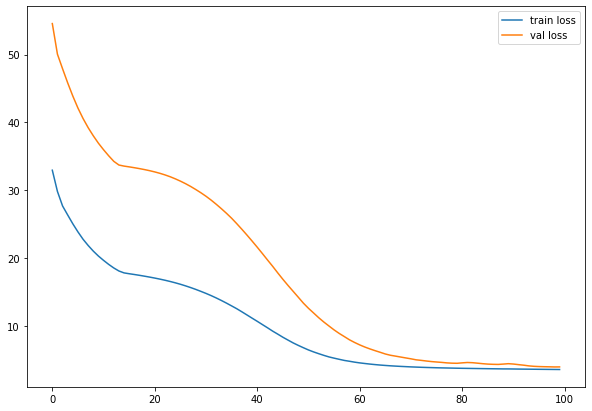

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 7))

plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')

plt.legend()
plt.show()

In [33]:
# [총 loss, output1 loss, output2 loss, output3 loss]
model.evaluate(X, [y1, y2, y3])

150/150 [==============================] - 0s 219us/sample - loss: 3.5849 - petal_width_output_loss: 1.9781 - petal_length_output_loss: 0.4957 - species_output_loss: 1.1342


[3.584922161102295, 1.978129, 0.49566594, 1.1341782]

In [36]:
X[:2]

array([[5.1, 3.5],
       [4.9, 3. ]])

In [35]:
# 추론
model.predict(X[:2])

[array([[3.3693051],
        [3.2185864]], dtype=float32),
 array([[1.021378 ],
        [0.9873012]], dtype=float32),
 array([[0.3224151 , 0.38096467, 0.29662025],
        [0.31925625, 0.38064748, 0.30009624]], dtype=float32)]

In [37]:
y1[:2]

array([1.4, 1.4])

In [38]:
y2[:2]

array([0.2, 0.2])

In [39]:
y3[:2]

array([0, 0])

## 다중 입력 모델
- 가정 
    - IRIS 꽃 데이터 + 꽃의 사진을 입력해서 꽃의 종류를 예측
- X: 꽃 데이터, 꽃 사진
- y: 꽃 종류

In [41]:
iris_info_tensor = layers.Input((4, ))
x1 = layers.Dense(32, activation = 'relu')(iris_info_tensor)
x1 = layers.Dense(16, activation = 'relu')(x1)

iris_img_tensor = layers.Input((16, 16, 1))
x2 = layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(iris_img_tensor)
x2 = layers.Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(x2)
x2 = layers.MaxPool2D(padding = 'same')(x2)

x3 = layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x2)
x3 = layers.Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x3)
x3 = layers.MaxPool2D(padding = 'same')(x3)
x3 = layers.GlobalAveragePooling2D()(x3)

# 합치기
x4 = layers.concatenate([x1, x3])
x5 = layers.Dropout(0.2)(x4)
output_tensor = layers.Dense(units = 3, activation = 'softmax')(x5)

model = models.Model([iris_info_tensor, iris_img_tensor], output_tensor)

In [42]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 16, 16, 32)   320         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 16, 16, 32)   9248        conv2d_17[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 8, 8, 32)     0           conv2d_18[0][0]                  
____________________________________________________________________________________________

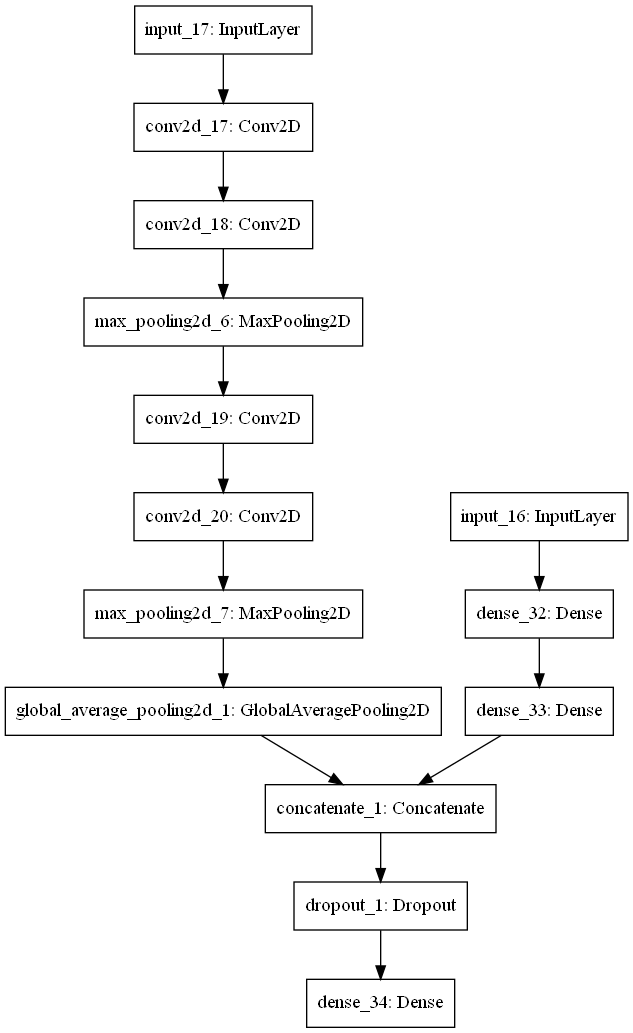

In [44]:
keras.utils.plot_model(model)

In [46]:
model.compile(optimizer = 'adam',
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy'])